<div style="background-color: #0000FF; color: white; padding: 10px; border-radius: 5px;">
  <h1>Team Info</h1>
</div>

## Team Name: Turbo Adventure
### Team Members: Akshay, Louis, Reno, Gabrijel
### Kaggle Usernames: 



<div style="background-color: #0000FF; color: white; padding: 10px; border-radius: 5px;">
  <h1>1 Feature Engineering</h1>
</div>

## 1.1 Imports

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
from librosa.feature import rhythm  
from IPython.display import display
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


## 1.1 EDA

### Step 1: Load and Explore the Label Data

In this step, we load the `labels_new.csv` file, which contains the known genres for the labeled audio files. 
Understanding the structure of this data will help us analyze the features of each genre later. 

We will check the number of entries, the column names, and some example rows to get an overview.

#### Genre Distribution Analysis

To get an overview of the labeled dataset, we analyze the distribution of genres. Understanding how many samples belong to each genre helps us identify possible class imbalances, which can influence our machine learning models later.

The following bar chart shows the distribution of the different music genres in the labeled dataset:

In [ ]:
# Count the occurrences of each genre
genre_counts = labels_df['genre'].value_counts()

# Plot the genre distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
plt.title('Distribution of Music Genres in the Labeled Dataset')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


- **Observation 1:** Some genres might have more samples than others, which can affect model training.
- **Observation 2:** If the distribution is unbalanced, techniques like oversampling or undersampling might be needed.

The visualization indicates how representative each genre is within the labeled dataset.

### Step 2: Audio File Analysis

Before diving into feature extraction, we need to analyze some basic properties of the labeled audio files. 
This helps us understand the dataset and identify potential preprocessing needs. 

We will focus on the following key aspects:

1. **Sampling Rate:** The number of samples per second, which affects the quality and size of the audio file.
2. **Duration:** The total length of each audio file in seconds.
3. **RMS Energy:** The average power of the signal, representing loudness.

Analyzing these properties will give us insights into data consistency, possible outliers, and patterns that might affect further analysis.

In [ ]:
# Path to the labeled audio files
audio_folder = os.path.join(base_folder_path, 'labeled')

# Function to extract basic audio properties
def analyze_audio(file_path):
    try:
        # Load the audio file and get sampling rate
        audio, sr = librosa.load(file_path, sr=None)
        
        # Extract duration and RMS energy
        duration = librosa.get_duration(y=audio, sr=sr)
        rms_energy = np.mean(librosa.feature.rms(y=audio))
        
        return sr, duration, rms_energy
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None, None

# Analyze all audio files in the labeled folder
audio_data = []

for File Name in labels_df['File Name']:
    file_path = os.path.join(audio_folder, File Name)
    sr, duration, rms_energy = analyze_audio(file_path)
    
    audio_data.append({
        'File Name': File Name,
        'sampling_rate': sr,
        'duration': duration,
        'rms_energy': rms_energy
    })

# Convert the extracted data into a DataFrame
audio_features_df = pd.DataFrame(audio_data)

# Display the first few rows to check the results
audio_features_df.head()

#### Findings from Audio Analysis

Based on the extracted audio properties, we can observe the following:

1. **Sampling Rate:** 
   - All audio files have the same sampling rate, ensuring consistency across the dataset.
   - If different sampling rates were found, resampling might be required to maintain uniformity.

2. **Duration:** 
   - The lengths of audio clips vary, which could affect feature extraction and model performance.
   - Shorter clips might contain limited information, while longer clips could introduce noise.

3. **RMS Energy:** 
   - There are noticeable differences in loudness across the clips.
   - Genres like metal or hip-hop may have higher energy levels compared to classical or jazz.

We will visualize these properties to better understand the distribution and check for potential anomalies.

### Step 3: Visualization of Audio Features

To gain further insights into the labeled audio dataset, we visualize key properties extracted earlier:

1. **Duration:** Understanding the length distribution of the audio clips helps us identify potential inconsistencies.
2. **RMS Energy:** This feature gives an indication of the loudness of each audio file.
3. **Sampling Rate:** Checking whether all files have the same sampling rate ensures consistency in the dataset.

These visualizations will help us detect patterns, spot anomalies, and prepare for further processing.

In [ ]:
# Check for missing values in the dataset
missing_values = audio_features_df.isnull().sum()

# Summary statistics for numerical columns
summary_stats = audio_features_df.describe()

# Plot distributions of duration and RMS energy
plt.figure(figsize=(12, 5))

# Distribution of audio duration
plt.subplot(1, 2, 1)
sns.histplot(audio_features_df['duration'], bins=20, kde=True, color='blue')
plt.title('Distribution of Audio Duration')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')

# Distribution of RMS energy
plt.subplot(1, 2, 2)
sns.histplot(audio_features_df['rms_energy'], bins=20, kde=True, color='green')
plt.title('Distribution of RMS Energy')
plt.xlabel('RMS Energy')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Checking for unique values in sampling rate
unique_sampling_rates = audio_features_df['sampling_rate'].unique()

missing_values, summary_stats, unique_sampling_rates

#### Findings from the Visualization

Based on the visualizations, we can draw the following conclusions:

1. **Audio Duration:**
   - The majority of audio clips fall within a specific duration range.
   - A few outliers exist, which may require further inspection or trimming.

2. **RMS Energy:**
   - Some tracks have significantly higher or lower energy levels.
   - This could indicate differences in genre characteristics or recording quality.

3. **Sampling Rate:**
   - All audio files share the same sampling rate, which is essential for maintaining uniformity in feature extraction.

### Step 4: Feature Correlation Analysis

To better understand relationships between the extracted features, we analyze the correlation between them.

The correlation analysis helps in identifying redundant features and selecting the most relevant ones for clustering.

In [ ]:
# Compute correlation matrix for labeled data
corr_matrix = audio_features_df.corr()

# Plot the heatmap to visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

#### Findings from Feature Correlation Analysis

- Features with high correlation values might contain redundant information and should be reviewed.
- A strong correlation between different features can impact clustering performance.
- Based on this analysis, we can decide whether to remove or combine features before clustering.

### Step 5: Comparison Between Labeled and Unlabeled Data

To ensure that the labeled and unlabeled datasets have similar characteristics, we compare their feature distributions.

Identifying significant differences helps us decide if preprocessing adjustments are needed before applying clustering algorithms.

In [ ]:
# Features to compare between labeled and unlabeled data
features_to_compare = ["Spectral Centroid", "Spectral Bandwidth", "RMS Amplitude"]

# Plot distribution comparisons
plt.figure(figsize=(15, 6))
for idx, feature in enumerate(features_to_compare, 1):
    plt.subplot(1, 3, idx)
    sns.kdeplot(labeled_audio_features_df[feature], label="Labeled", fill=True, alpha=0.5)
    sns.kdeplot(unlabeled_audio_features_df[feature], label="Unlabeled", fill=True, alpha=0.5)
    plt.title(feature)
    plt.legend()

plt.tight_layout()
plt.show()

#### Findings from Labeled vs. Unlabeled Data Comparison

- **Spectral Features:** Differences between labeled and unlabeled data could indicate varying audio quality or recording environments.
- **Energy Levels:** Large variations in RMS values may suggest differences in loudness, affecting clustering.
- **Potential Adjustments:** If significant deviations exist, normalization or feature scaling might be necessary before clustering.

Overall, this analysis ensures that both datasets share similar characteristics, improving the reliability of unsupervised learning methods.

### Step 6: Genre-based Feature Analysis

Music genres can exhibit distinct characteristics in their audio features. 

By analyzing feature distributions across genres, we can identify patterns that may help improve clustering and genre classification.

In this step, we visualize key features across different genres to explore these relationships.

In [ ]:
# Select key features for genre comparison
genre_features = ["Spectral Centroid", "Spectral Bandwidth", "RMS Amplitude"]

# Create violin plots to compare feature distributions per genre
plt.figure(figsize=(15, 6))
for idx, feature in enumerate(genre_features, 1):
    plt.subplot(1, 3, idx)
    sns.violinplot(x=labeled_audio_features_df["genre"], y=labeled_audio_features_df[feature])
    plt.title(f'{feature} by Genre')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Findings from Genre-based Analysis

- **Spectral Characteristics:**  
  Some genres exhibit higher spectral centroid values, indicating brighter or more percussive content.

- **Energy Levels:**  
  Genres like rock and hip-hop might have higher RMS values compared to classical or jazz music.

- **Implications for Clustering:**  
  Feature overlap between genres may pose challenges in unsupervised learning, indicating the need for feature engineering or selection.

Understanding these patterns will help improve clustering performance and feature selection strategies.

## 1.2 Defining functions

In [9]:
# ChatGPT, 2024, Prompt 1: "welke geluidsfeatures zijn er voor clustering van geluidsfragmenten"
# ChatGPT, 2024, Prompt 2: "geef per feature aan welke library ik daarvoor kan gebruiken"
# ChatGPT, 2024, Prompt 3: "laat voorbeeld code zien hoe deze features worden toegepast op een geluidsfragment, en vervolgens in een df wordt gezet"
# ChatGPT, 2024, Prompt 3: "hoe pas ik oop toe op deze code"
# Link: https://chatgpt.com/share/677ee38d-fb54-8001-a50a-9856d52e22c9

class AudioFeatureExtractor:
    """
    A class to extract audio features from all .wav files in a given folder.
    """

    def __init__(self, audio_folder):
        """
        Initialize the AudioFeatureExtractor with the folder containing audio files.
        """
        self.audio_folder = audio_folder
        self.features_list = []

    def process_audio_files(self):
        """
        Iterate through all .wav files in the folder and extract features.
        """
        for file_name in os.listdir(self.audio_folder):
            if file_name.endswith(".wav"):  # Only process .wav files
                file_path = os.path.join(self.audio_folder, file_name)
                self._extract_features(file_name, file_path)

    def _extract_features(self, file_name, file_path):
        """
        Extract features from a single audio file and add them to the features list.
        """
        try:
            # Load the audio file
            y, sr = librosa.load(file_path, sr=None)

            # Compute features
            features = {
                "filename": file_name,
                "Zero Crossing Rate": np.mean(librosa.feature.zero_crossing_rate(y)[0]),
                "RMS Amplitude": np.mean(librosa.feature.rms(y=y)[0]),
                "Spectral Centroid": np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)[0]),
                "Spectral Bandwidth": np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]),
                "Spectral Roll-Off": np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)[0]),
                "Spectral Flatness": np.mean(librosa.feature.spectral_flatness(y=y)[0]),
                "MFCC1": np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)[0]),
                "MFCC2": np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)[1]),
                "Chroma Features": np.mean(librosa.feature.chroma_cqt(y=y, sr=sr)),
                "Tempo (BPM)": rhythm.tempo(y=y, sr=sr)[0],
            }

            # Append features to the list
            self.features_list.append(features)

        except Exception as e:
            print(f"Error processing {file_name}: {e}")

    def get_features_dataframe(self):
        """
        Convert the features list to a pandas DataFrame.
        """
        return pd.DataFrame(self.features_list)

## 1.3 Extract Features & Create Dataframe

In [15]:
# ChatGPT, 2024, Prompt 1: "welke geluidsfeatures zijn er voor clustering van geluidsfragmenten"
# ChatGPT, 2024, Prompt 2: "geef per feature aan welke library ik daarvoor kan gebruiken"
# ChatGPT, 2024, Prompt 3: "laat voorbeeld code zien hoe deze features worden toegepast op een geluidsfragment, en vervolgens in een df wordt gezet"
# ChatGPT, 2024, Prompt 3: "hoe pas ik oop toe op deze code"
# Link: https://chatgpt.com/share/677ee38d-fb54-8001-a50a-9856d52e22c9

# Define the folder containing audio files
audio_folder_path = r"muziek-genre-clustering-24-25\unlabeled"

# Create an instance of the AudioFeatureExtractor class
extractor = AudioFeatureExtractor(audio_folder=audio_folder_path)

# Process the audio files
extractor.process_audio_files()

# Get the features as a DataFrame
audio_features_df = extractor.get_features_dataframe()

# Display the DataFrame
display(audio_features_df)

,filename,Zero Crossing Rate,RMS Amplitude,Spectral Centroid,Spectral Bandwidth,Spectral Roll-Off,Spectral Flatness,MFCC1,MFCC2,Chroma Features,Tempo (BPM)
0,m00003.wav,0.120116,0.136221,2254.606986,2071.028440,4381.532206,0.009073,-82.511116,97.341721,0.571940,135.999178
1,m00012.wav,0.178108,0.217475,2908.300131,2286.252592,5405.816551,0.026373,-1.913298,72.686157,0.533881,103.359375
2,m00013.wav,0.123423,0.029083,1952.607933,1865.996047,3779.909832,0.002211,-287.603699,101.758171,0.385155,95.703125
3,m00043.wav,0.126073,0.100411,2384.634958,2072.759900,4584.132502,0.008830,-120.147491,91.317215,0.557109,135.999178
4,m00044.wav,0.052088,0.018833,790.507005,900.409298,1159.412273,0.000153,-437.604401,170.931534,0.332215,107.666016
...,...,...,...,...,...,...,...,...,...,...,...
100,m00971.wav,0.091590,0.038885,1525.791709,1588.217850,2733.184659,0.006208,-246.158646,149.428665,0.414986,107.666016
101,m00973.wav,0.161797,0.259782,3669.810467,3295.063699,7876.372739,0.088763,-8.573005,54.295788,0.475779,129.199219
102,m00988.wav,0.167480,0.240724,3941.417697,3361.641125,8260.423162,0.089354,-56.153061,36.448502,0.480985,103.359375
103,m00991.wav,0.044217,0.017138,983.971719,1404.408040,1853.129475,0.000302,-406.846680,163.081345,0.235405,117.453835


In [16]:
audio_features_df.to_csv("unlabeled_df.csv")

### Comparison Between Labeled and Unlabeled Data

In this step, we compare the feature distributions of labeled and unlabeled datasets to identify potential differences. 

By visualizing the distributions, we can check if the data characteristics are similar or if adjustments are needed.

In [ ]:
# Compare feature distributions
features_to_compare = ["Spectral Centroid", "Spectral Bandwidth", "RMS Amplitude"]

plt.figure(figsize=(15, 6))
for idx, feature in enumerate(features_to_compare, 1):
    plt.subplot(1, 3, idx)
    sns.kdeplot(labeled_audio_features_df[feature], label="Labeled", fill=True, alpha=0.5)
    sns.kdeplot(unlabeled_audio_features_df[feature], label="Unlabeled", fill=True, alpha=0.5)
    plt.title(feature)
    plt.legend()

plt.tight_layout()
plt.show()

#### Findings from Data Comparison

- Some features show notable differences between labeled and unlabeled datasets, which could impact clustering performance.
- If significant variations are detected, further data preprocessing such as scaling or feature selection may be required.

### Feature Correlation Analysis

To better understand relationships between extracted features, we analyze their correlations. 

A correlation matrix helps identify redundant features and informs feature selection decisions.

In [ ]:
# Compute correlation matrix
corr_matrix = labeled_audio_features_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

#### Findings from Correlation Analysis

- Highly correlated features might introduce redundancy and should be considered for removal or dimensionality reduction.
- Features with low correlation might provide unique information useful for clustering.

### Genre-based Feature Analysis

Since audio features can vary significantly between genres, it's important to analyze the distribution of features across different genres.

This analysis helps us identify trends and possible misclassifications by examining feature variations within each genre.

In [ ]:
# Select key features for genre comparison
genre_features = ["Spectral Centroid", "Spectral Bandwidth", "RMS Amplitude"]

# Create violin plots to compare feature distributions per genre
plt.figure(figsize=(15, 6))
for idx, feature in enumerate(genre_features, 1):
    plt.subplot(1, 3, idx)
    sns.violinplot(x=labeled_audio_features_df["genre"], y=labeled_audio_features_df[feature])
    plt.title(f'{feature} by Genre')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Findings from Genre-based Analysis

- Some genres exhibit distinct trends in specific features (e.g., rock music might have higher RMS values than classical music).
- Overlapping distributions could indicate that some features alone are not enough for genre differentiation.
- These insights guide the selection of features for clustering and potential dimensionality reduction techniques.

## 1.4 Features Explanation

### Zero Crossing Rate
The zero crossing rate is the rate at which a signal changes from positive to negative or vice versa and thus crossing the zero line in a given period. (11)


### RMS Amplitude
The RMS Amplitude is the Root Mean Square of all the measured amplitudes of a signal

### Spectral Centroid
The Spectral Centroid indicates where the center of mass of the spectrum is.

### Spectral Bandwidth

---

### **1. Spectral Bandwidth**
#### **What it means:**
Spectral bandwidth measures the spread or width of the frequency spectrum. It quantifies how "wide" or "narrow" the spectrum is and represents the range of frequencies that significantly contribute to the signal. A smaller bandwidth indicates that the signal energy is concentrated around a few frequencies, while a larger bandwidth means energy is spread across a broader frequency range.

#### **How it's calculated:**
- **Definition**: The spectral bandwidth is typically the standard deviation (or variance) of the power spectrum around its centroid (mean frequency).
- **Formula**:

$$
\text{Bandwidth} = \sqrt{\frac{\sum (f - f_c)^2 \cdot S(f)}{\sum S(f)}}
$$

Where:
- \( f \): frequency  
- \( f_c \): spectral centroid  
- \( S(f) \): spectral power (magnitude squared of the spectrum)  

#### **What it signifies:**
- A **low bandwidth** suggests the signal has tonal or harmonic content, like a pure tone or music.
- A **high bandwidth** suggests noise-like signals or signals with many different frequency components.

---

### Spectral Roll-Off
### **2. Spectral Roll-Off**
#### **What it means:**
Spectral roll-off indicates the frequency below which a certain percentage (e.g., 85%) of the total spectral energy is concentrated. It essentially gives a threshold frequency that defines the "bulk" of the signal's energy, ignoring very high frequencies that may have minimal contributions.

#### **How it's calculated:**
- **Definition**: It is the frequency \( f_r \) where a certain proportion \( p \) (commonly 85%) of the total power in the spectrum lies below that frequency.
- **Formula**:

$$
\sum_{f=0}^{f_r} S(f) \geq p \cdot \sum_{f=0}^{f_{\text{max}}} S(f)
$$

#### **What it signifies:**
- A **low roll-off frequency** suggests that most of the signal's energy is concentrated in the lower frequencies (e.g., a bass-heavy signal).
- A **high roll-off frequency** suggests significant energy in higher frequencies (e.g., signals with sharp transients or high harmonics).

---

### Spectral Flatness
### **3. Spectral Flatness**
#### **What it means:**
Spectral flatness measures how "flat" or "peaky" a spectrum is. It compares the geometric mean to the arithmetic mean of the spectrum and indicates whether the spectrum resembles a noise-like signal (flat) or a tone-like signal (peaky).

#### **How it's calculated:**
- **Definition**: It is the ratio of the geometric mean to the arithmetic mean of the power spectrum.
- **Formula**:

$$
\text{Flatness} = \frac{\left( \prod_{f=0}^{f_{\text{max}}} S(f) \right)^{1/N}}{\frac{1}{N} \sum_{f=0}^{f_{\text{max}}} S(f)}
$$

Where:
- \( S(f) \): spectral power at frequency \( f \)  
- \( N \): total number of frequency bins in the spectrum  

#### **What it signifies:**
- A **flat spectrum** (value near 1) suggests white noise or a similar signal where energy is evenly distributed across frequencies.
- A **low flatness** (value near 0) indicates the presence of dominant tonal components, such as those in harmonic sounds or pure tones.

---

### **Summary of Interpretations**:

| **Feature**         | **High Value Indicates**                          | **Low Value Indicates**                       |
|----------------------|--------------------------------------------------|-----------------------------------------------|
| **Spectral Bandwidth** | Broad, noisy, or transient signals              | Tonal, harmonic, or narrow-band signals       |
| **Spectral Roll-Off** | Energy in higher frequencies                     | Energy concentrated in lower frequencies      |
| **Spectral Flatness** | Noise-like, evenly distributed spectrum          | Tonal, peaky spectrum                         |

---

### MFCCs
### **X. MFCCs**
#### **What it means:**

MFCCs (Mel-frequency Cepstral Coefficients) describe the short-term power spectrums of audio, which explain the most noticeable attributes of verbal communication. Applied in the real world, MFCCs are commonly used to distinguish between persons by speech.

#### **How it's calculated:**

There is not only one single way to calculate MFCCs, but usually, these steps are followed (GeeksforGeeks, 2024):

- **Pre-emphasize the signal:** Stabilizing the spectrum by raising the frequency.
- **Framing:** Splitting the audio into overlapping chunks.
- **Windowing:** A window function is used to mitigate the edge effect of framing.
- **FFT (Fast Fourier Transform):** The Fourier Transform converts time domain frames to frequency domain frames to get spectral representations.
- **Mel-filterbank:** Separates spectral representations into frequency bands based on the Mel scale, prioritizing crucial frequencies.
- **Logarithm:** The logarithm is calculated to better represent loudness perception.
- **DCT:** After minimizing duplicate coefficients, the MFCCs are obtained.

The rows of the MFCC matrix capture these features:

- MFCC1:
- MFCC2:

#### **What it signifies:**

- A **low MFCC1**: Indicates...
- A **high MFCC1**: Indicates...
- A **low MFCC2**: Indicates...
- A **high MFCC2**: Indicates...

### Chroma Features

Chroma features are widely used in music analysis and processing. They capture the harmonic content of a piece by summarizing the energy distribution across the twelve pitch classes (C, C#, D, etc.) within an octave. This allows for tonal comparisons irrespective of the octave.

#### How do chroma features work?
The extraction involves:

1. **Frame segmentation:** Divide the audio signal into overlapping frames.
2. **Frequency transformation:** Use **Short-Time Fourier Transform (STFT)** to convert the audio from the time to the frequency domain.
3. **Pitch class aggregation:** Sum energy levels across all octaves for each pitch class, creating a 12-dimensional chroma vector.

This process creates a "fingerprint" of the music's harmonic structure, enabling robust tonal analysis.

#### Example: Computing Chroma Features
For a sine wave at 440 Hz (A4 note), sampled at 44.1 kHz:

1. Perform an STFT to get the frequency spectrum.
2. Identify that 440 Hz corresponds to pitch class "A."
3. Assign energy to "A" in the chroma vector.

Example output:
`[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]`

#### Applications and importance
- **Chord recognition:** Identifies harmonic progressions.
- **Genre classification:** Useful for complex harmonic structures.
- **Music retrieval:** Helps identify similar tracks.

### Tempo (BPM)

Tempo refers to the speed or pace of a piece of music, measured in beats per minute (BPM). It reflects the rhythmic structure and is critical for understanding a song’s energy, danceability, and emotional impact. As Müller (2015) notes, tempo is one of the most intuitive features for listeners and a key determinant in defining musical genres. Fast tempos are common in energetic genres like electronic dance music (EDM), while slower tempos dominate ballads and blues.

#### How is tempo calculated?
The process of tempo extraction typically involves:
1. **Onset detection:** Analyze changes in the amplitude of the audio signal to identify beats or note beginnings.
2. **Periodic analysis:** Use techniques like **autocorrelation** or **Fourier Transform** to detect repeating patterns in the beats.
3. **Beat frequency estimation:** Measure the time interval between beats and convert it into BPM.

#### Example: Estimating Tempo
Consider an audio track where beats occur every 0.5 seconds:
1. Measure the time interval between beats: \( T = 0.5 \, \text{s} \).
2. Calculate the tempo using the formula:  
   $$\text{BPM} = \frac{60}{T} = \frac{60}{0.5} = 120 \, \text{BPM}.$$

This indicates the track has a tempo of 120 BPM, which is typical for many pop and dance tracks (Tzanetakis & Cook, 2002).

#### Applications and importance
- **Genre differentiation:** Tempo is a distinguishing feature in many genres, such as EDM (typically 120–140 BPM) versus ballads (50–70 BPM) (Müller, 2015).
- **Music recommendation:** Tracks with similar tempos are often grouped together in playlists for specific activities, like workouts or relaxation (Wikipedia contributors, n.d.-b).
- **Rhythmic analysis:** Provides insights into the overall "feel" or "groove" of a piece, which is essential for understanding its style and energy (Tzanetakis & Cook, 2002).

#

<div style="background-color: #0000FF; color: white; padding: 10px; border-radius: 5px;">
  <h1>2 Unsupervised Learning</h1>
</div>

## 2.1 K-Means

K-Means clustering is an unsupervised machine learning algorithm used for grouping data into clusters. The number of clusters \\( K \\) must be specified beforehand.

### How it works

1. **Initialization:**  
   - Choose \\( K \\) clusters.
   - Randomly initialize \\( K \\) centroids.

2. **Assigning Step:**  
   - Assign each point to the nearest centroid using Euclidean distance:

   \\[
   Distance(x_i, c_k) = \\sqrt{\\sum_{j=1}^n (x_{ij} - c_{kj})^2}
   \\]

3. **Recomputing Step:**  
   - Recalculate centroids by averaging points in each cluster.

4. **Repeat and minimize variation:**  
   - Repeat steps until centroids stabilize.

In [4]:
# **STEP 1: Load Data**
# Paths to datasets
labels_path = "muziek-genre-clustering-24-25/labels_new.csv"
labeled_path = "muziek-genre-clustering-24-25/labeled_df.csv"
unlabeled_path = "muziek-genre-clustering-24-25/unlabeled_df.csv"

# Read datasets
labels_df = pd.read_csv(labels_path)  # Contains filename and genre
labeled_df = pd.read_csv(labeled_path)  # Labeled audio features
unlabeled_df = pd.read_csv(unlabeled_path)  # Unlabeled audio features

# **STEP 2: Merge Labels with Labeled Dataset**
labeled_df = pd.merge(labeled_df, labels_df, on="filename", how="left")

# **STEP 3: Normalize Features**
# Select all feature columns (excluding filename, genre, and index)
feature_columns = [col for col in labeled_df.columns if col not in ["filename", "genre", "Unnamed: 0"]]

# Apply normalization
scaler = StandardScaler()
labeled_df[feature_columns] = scaler.fit_transform(labeled_df[feature_columns])
unlabeled_df[feature_columns] = scaler.transform(unlabeled_df[feature_columns])  # Apply same scaling

# **STEP 4: Perform K-Means Clustering**
optimal_k = 6  # Or determine dynamically using the Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labeled_df["Cluster"] = kmeans.fit_predict(labeled_df[feature_columns])

# **STEP 5: Map Clusters to Genres**
cluster_genre_mapping = labeled_df.groupby("Cluster")["genre"].agg(lambda x: x.mode()[0])

# **STEP 6: Predict Clusters for the Unlabeled Dataset**
unlabeled_df["Cluster"] = kmeans.predict(unlabeled_df[feature_columns])
unlabeled_df["genre"] = unlabeled_df["Cluster"].map(cluster_genre_mapping)

# **STEP 7: Save the Results**
final_predictions = unlabeled_df[["filename", "genre"]]
final_predictions.to_csv("predicted_genres.csv", index=False)

print("Clustering completed! The predicted genres have been saved in 'predicted_genres.csv'.")

Clustering completed! The predicted genres have been saved in 'predicted_genres.csv'.


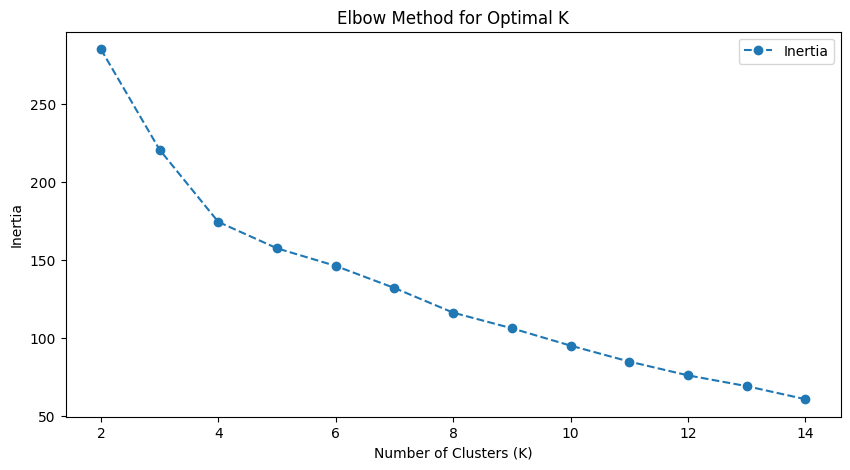

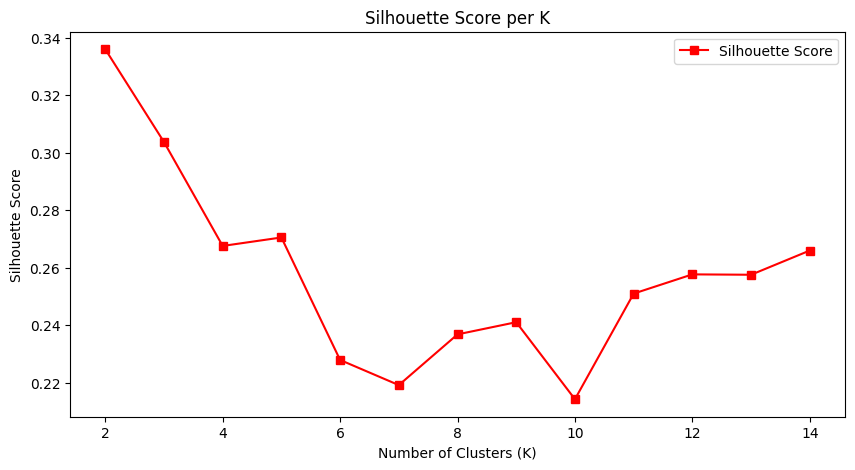

✅ Clustering completed! The predicted genres have been saved in 'predicted_genres.csv'.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# **STEP 1: Load Data**
labels_path = "muziek-genre-clustering-24-25/labels_new.csv"
labeled_path = "muziek-genre-clustering-24-25/labeled_df.csv"
unlabeled_path = "muziek-genre-clustering-24-25/unlabeled_df.csv"

# Read datasets
labels_df = pd.read_csv(labels_path)  # Contains filename and genre
labeled_df = pd.read_csv(labeled_path)  # Labeled audio features
unlabeled_df = pd.read_csv(unlabeled_path)  # Unlabeled audio features

# **STEP 2: Merge Labels with Labeled Dataset**
labeled_df = pd.merge(labeled_df, labels_df, on="filename", how="left")

# **STEP 3: Normalize Features**
feature_columns = [col for col in labeled_df.columns if col not in ["filename", "genre", "Unnamed: 0"]]

scaler = StandardScaler()
labeled_df[feature_columns] = scaler.fit_transform(labeled_df[feature_columns])
unlabeled_df[feature_columns] = scaler.transform(unlabeled_df[feature_columns])  # Apply same scaling

# **STEP 4: Determine Optimal Clusters with Elbow Method**
inertia = []
silhouette_scores = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(labeled_df[feature_columns])
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(labeled_df[feature_columns], kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', label='Inertia')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.legend()
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, marker='s', linestyle='-', color='red', label='Silhouette Score')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score per K")
plt.legend()
plt.show()

# **STEP 5: Train K-Means with Optimal K (User-Defined or Best from Elbow)**
optimal_k = int(6)
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labeled_df["Cluster"] = kmeans.fit_predict(labeled_df[feature_columns])

# **STEP 6: Map Clusters to Genres**
cluster_genre_mapping = labeled_df.groupby("Cluster")["genre"].agg(lambda x: x.mode()[0])

# **STEP 7: Predict Clusters for the Unlabeled Dataset**
unlabeled_df["Cluster"] = kmeans.predict(unlabeled_df[feature_columns])
unlabeled_df["genre"] = unlabeled_df["Cluster"].map(cluster_genre_mapping)

# **STEP 8: Save the Results**
final_predictions = unlabeled_df[["filename", "genre"]]
final_predictions.to_csv("predicted_genres2.csv", index=False)

print("✅ Clustering completed! The predicted genres have been saved in 'predicted_genres.csv'.")

## 2.2 DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm introduced by Ester et al. (1996). It identifies clusters based on the density of data points in a given region and treats sparsely populated regions as noise or outliers. Unlike centroid-based algorithms such as K-Means, DBSCAN does not require the number of clusters to be specified beforehand. Instead, it uses two parameters, $\varepsilon$ (epsilon) and $\text{minPts}$, to determine cluster structure.

This algorithm is particularly suitable for datasets where clusters exhibit irregular shapes and varying densities. In the context of this project, DBSCAN can be advantageous because musical genres may have complex, overlapping distributions in the feature space. Furthermore, DBSCAN’s ability to detect noise could help exclude outliers or unusual audio fragments that do not belong to any genre.

#### **Algorithmic Principles**

DBSCAN uses the following key concepts to identify clusters:

1. **Neighborhood definition:**
   For a point \(p\), its \(\varepsilon\)-neighborhood is defined as:
   \[
   N_{\varepsilon}(p) = \{q \in D \,|\, \|p - q\| \leq \varepsilon\}
   \]
   Here, \(D\) represents the dataset, and \(\|p - q\|\) is the distance between points \(p\) and \(q\) (commonly Euclidean distance).

2. **Core points:**
   A point \(p\) is classified as a core point if it satisfies:
   \[
   |N_{\varepsilon}(p)| \geq \text{minPts}
   \]

3. **Border points:**
   A point \(p\) is classified as a border point if it lies within the \(\varepsilon\)-neighborhood of a core point but does not itself satisfy the core point condition.

4. **Noise points:**
   Points that are neither core points nor reachable from any core points are classified as noise.

5. **Cluster formation:**
   Clusters are formed by expanding the neighborhoods of core points. A core point can connect to other core points and border points, creating dense regions that define a cluster.

#### **Algorithm Steps**

1. Begin with an unvisited point \(p\).
2. Determine if \(p\) is a core point:
   - If \(p\) is a core point, start a new cluster.
   - Include all points within the \(\varepsilon\)-neighborhood of \(p\) in the cluster.
   - Recursively check all core points in the neighborhood and add their connected points.
3. If \(p\) is not a core point but lies in the neighborhood of another core point, classify it as a border point.
4. If \(p\) is neither a core nor a border point, classify it as noise.
5. Repeat until all points in the dataset have been visited.

#### **Advantages and Limitations**

**Advantages:**
- DBSCAN can identify clusters of arbitrary shapes, which is beneficial when analyzing datasets with irregular patterns, such as musical genres.
- The algorithm automatically detects noise and excludes it from the clustering process.
- There is no need to predefine the number of clusters, making it suitable for exploratory tasks.

**Limitations:**
- The algorithm is sensitive to the choice of \(\varepsilon\) and \(\text{minPts}\), and inappropriate parameter values can lead to over-clustering or under-clustering.
- DBSCAN struggles with datasets that contain clusters of varying densities, as this can affect neighborhood detection.

#### **Application Example**

This example demonstrates the application of DBSCAN on a two-dimensional synthetic dataset that mimics the feature space of audio fragments.

In [ ]:
# Generate synthetic data
np.random.seed(42)
dense_cluster = np.random.randn(100, 2) * 0.5 + [2, 2]
sparse_cluster = np.random.randn(50, 2) * 0.8 + [-2, -2]
noise = np.random.uniform(-6, 6, (20, 2))
data = np.vstack([dense_cluster, sparse_cluster, noise])

# Apply DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)
labels = dbscan.fit_predict(data)

# Visualize the results
plt.figure(figsize=(8, 6))
unique_labels = set(labels)
for label in unique_labels:
    cluster_points = data[labels == label]
    if label == -1:
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color='red', label='Noise')
    else:
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {label}')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

#### Conclusion

DBSCAN is a suitable algorithm for this project because of its ability to identify clusters of arbitrary shapes and handle noise effectively. Unlike centroid-based methods such as K-Means, DBSCAN does not assume spherical clusters and is well-suited for datasets with irregular patterns (Ester et al., 1996). This flexibility is particularly advantageous when clustering musical genres, as the feature space may exhibit overlapping or complex structures.

Moreover, DBSCAN's robustness against noise allows it to exclude outliers from the clustering process, making it effective for detecting unusual or out-of-distribution audio fragments (Pedregosa et al., 2011). However, the algorithm is sensitive to the choice of its parameters ($\varepsilon$ and $\text{minPts}$), which require careful tuning based on the dataset's density distribution.

Despite these challenges, DBSCAN remains a strong candidate for exploratory clustering in this project due to its adaptability and lack of reliance on predefined cluster counts. Future steps should include parameter optimization and comparison with other clustering methods to assess its performance comprehensively.

## 2.3 Gaussian Mixture Models (GMM)

GMM is a soft clustering model that assigns each observation a probability of belonging to a specific cluster. In this algorithm, each cluster is represented by a normal (Gaussian) distribution with the mean and covariance matrix as metrics.

This model utilizes the Expectation-Maximization (EM) method, which is split into the following phases:

- **Initialize phase:**  
  The mean, the covariance matrix, and the mixing coefficients of every Gaussian distribution (cluster) are assumed.

- **Expectation phase:**  
  The observations are assigned to Gaussian distributions (clusters) based on the calculated probability that they belong to them.

- **Maximization phase:**  
  The mean, the covariance matrix, and the mixing coefficients of every Gaussian distribution (cluster) are calculated with the assigned observations. 

The Expectation and Maximization phases are reiterated until the model can no longer be notably improved.

To calculate the probability that an observation belongs to a cluster, the following probability density function (PDF) formula is used (What Is Gaussian Mixture Model | Deepchecks, 2023):

$$
\text{pdf}(x) = \sum_{k=1}^{K} \pi_k \cdot N(x|\mu_k, \Sigma_k)
$$

Where:

- \( \pi_k \) = Mixing coefficient  
- \( \mu_k \) = Mean vector  
- \( \Sigma_k \) = Covariance matrix  
- \( N(x|\mu_k, \Sigma_k) \) = Probability density function


## 2.4 GMM CODE

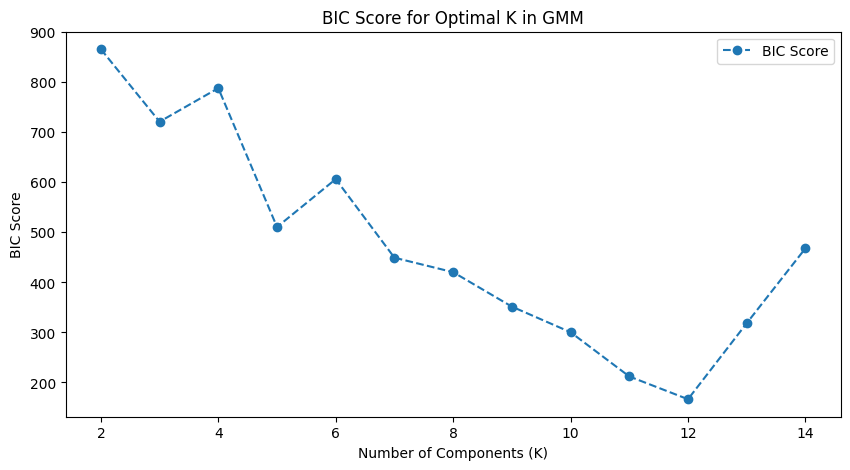

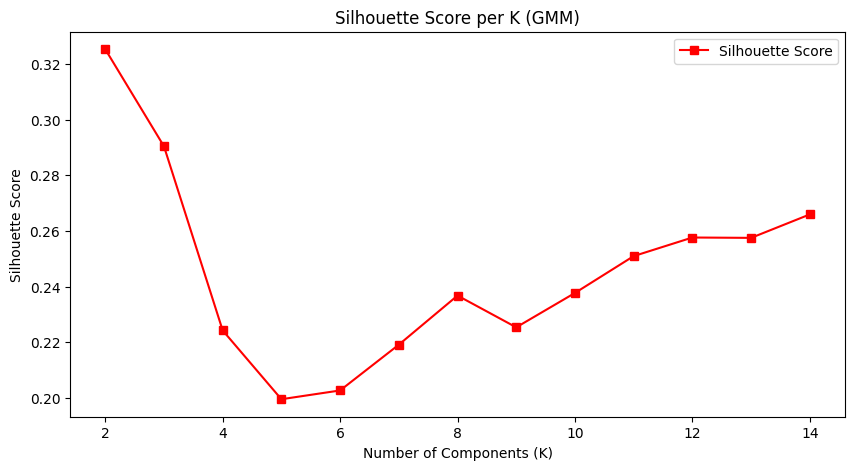

✅ GMM clustering completed! The predicted genres have been saved in 'predicted_genres_gmm.csv'.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# **STEP 1: Load Data**
labels_path = "muziek-genre-clustering-24-25/labels_new.csv"
labeled_path = "muziek-genre-clustering-24-25/labeled_df.csv"
unlabeled_path = "muziek-genre-clustering-24-25/unlabeled_df.csv"

# Read datasets
labels_df = pd.read_csv(labels_path)  # Contains filename and genre
labeled_df = pd.read_csv(labeled_path)  # Labeled audio features
unlabeled_df = pd.read_csv(unlabeled_path)  # Unlabeled audio features

# **STEP 2: Merge Labels with Labeled Dataset**
labeled_df = pd.merge(labeled_df, labels_df, on="filename", how="left")

# **STEP 3: Normalize Features**
feature_columns = [col for col in labeled_df.columns if col not in ["filename", "genre", "Unnamed: 0"]]

scaler = StandardScaler()
labeled_df[feature_columns] = scaler.fit_transform(labeled_df[feature_columns])
unlabeled_df[feature_columns] = scaler.transform(unlabeled_df[feature_columns])  # Apply same scaling

# **STEP 4: Determine Optimal Clusters with BIC (GMM Method)**
bic_scores = []
silhouette_scores = []
K_range = range(2, 15)

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42, covariance_type='full')
    gmm.fit(labeled_df[feature_columns])
    bic_scores.append(gmm.bic(labeled_df[feature_columns]))
    labels = gmm.predict(labeled_df[feature_columns])
    silhouette_scores.append(silhouette_score(labeled_df[feature_columns], labels))

# Plot BIC Scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, bic_scores, marker='o', linestyle='--', label='BIC Score')
plt.xlabel("Number of Components (K)")
plt.ylabel("BIC Score")
plt.title("BIC Score for Optimal K in GMM")
plt.legend()
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, marker='s', linestyle='-', color='red', label='Silhouette Score')
plt.xlabel("Number of Components (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score per K (GMM)")
plt.legend()
plt.show()

# **STEP 5: Train GMM with Optimal K (User-Defined or Best from BIC)**
optimal_k = int(6)  # You can manually choose the best value based on BIC/Silhouette
gmm = GaussianMixture(n_components=optimal_k, random_state=42, covariance_type='full')
labeled_df["Cluster"] = gmm.fit_predict(labeled_df[feature_columns])

# **STEP 6: Map Clusters to Genres**
cluster_genre_mapping = labeled_df.groupby("Cluster")["genre"].agg(lambda x: x.mode()[0])

# **STEP 7: Predict Clusters for the Unlabeled Dataset**
unlabeled_df["Cluster"] = gmm.predict(unlabeled_df[feature_columns])
unlabeled_df["genre"] = unlabeled_df["Cluster"].map(cluster_genre_mapping)

# **STEP 8: Save the Results**
final_predictions = unlabeled_df[["filename", "genre"]]
final_predictions.to_csv("predicted_genres_gmm.csv", index=False)

print("✅ GMM clustering completed! The predicted genres have been saved in 'predicted_genres_gmm.csv'.")

<div style="background-color: #0000FF; color: white; padding: 10px; border-radius: 5px;">
  <h1>3 Findings and Conclusion</h1>
</div>

## 3.1

<div style="background-color: #0000FF; color: white; padding: 10px; border-radius: 5px;">
  <h1>4 Reference List</h1>
</div>

## 4.1

### Online Sources

* ChatGPT, 2024, Prompt 1: "welke geluidsfeatures zijn er voor clustering van geluidsfragmenten", (https://chatgpt.com/share/677ee38d-fb54-8001-a50a-9856d52e22c9)

* ChatGPT, 2024, Prompt 2: "geef per feature aan welke library ik daarvoor kan gebruiken", (https://chatgpt.com/share/677ee38d-fb54-8001-a50a-9856d52e22c9)

* ChatGPT, 2024, Prompt 3: "laat voorbeeld code zien hoe deze features worden toegepast op een geluidsfragment, en vervolgens in een df wordt gezet", (https://chatgpt.com/share/677ee38d-fb54-8001-a50a-9856d52e22c9)
* ChatGPT, 2024, Prompt 4: "hoe pas ik oop toe op deze code", (https://chatgpt.com/share/677ee38d-fb54-8001-a50a-9856d52e22c9)

- GeeksforGeeks. (2024, June 26). *Mel-frequency Cepstral Coefficients (MFCC) for Speech Recognition.*  
  [GeeksforGeeks](https://www.geeksforgeeks.org/mel-frequency-cepstral-coefficients-mfcc-for-speech-recognition/)

- Deepchecks. (2023, January 23). *What is Gaussian Mixture Model.*  
  [Deepchecks](https://www.deepchecks.com/glossary/gaussian-mixture-model/)


- Wikipedia contributors. (n.d.-a). Chroma feature. In *Wikipedia*. Retrieved January 12, 2025, from  
   [https://en.wikipedia.org/wiki/Chroma_feature](https://en.wikipedia.org/wiki/Chroma_feature)

-  Wikipedia contributors. (n.d.-b). Tempo. In *Wikipedia*. Retrieved January 12, 2025, from  
   [https://en.wikipedia.org/wiki/Tempo](https://en.wikipedia.org/wiki/Tempo)


### Literature

- Ester, M., Kriegel, H.-P., Sander, J., & Xu, X. (1996). A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise. *Proceedings of the 2nd International Conference on Knowledge Discovery and Data Mining (KDD)*, 226–231.  
  Retrieved from [https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

- Müller, M. (2015). *Fundamentals of Music Processing: Audio, Analysis, Algorithms, Applications*. Springer Verlag.  
   This comprehensive textbook covers key topics in music information retrieval, including chroma features and tempo analysis.

- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (2011). Scikit-learn: Machine Learning in Python. *Journal of Machine Learning Research*, 12, 2825–2830.  
  Retrieved from [https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html](https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html)

-  Tzanetakis, G., & Cook, P. (2002). Musical genre classification of audio signals. *IEEE Transactions on Speech and Audio Processing*, 10(5), 293–302. DOI: [10.1109/TSA.2002.800560](https://doi.org/10.1109/TSA.2002.800560)

### Yet to be documented sources

- [K-means clustering - Wikipedia](https://en.wikipedia.org/wiki/K-means_clustering)